# "Tell me what you eat, I'll tell you where you're from "
## Project of Applied Data Analysis (Milestone 2)


The goal of this project is to make relevant observations on the different types of food people in a country used to eat and their link with the country itself. For this purpose, we have based this notebook on the dataset of **OpenFoodFacts**, found on https://world.openfoodfacts.org/data

Thus, we have planned to solve the following points:

### **1. Analysis of our dataset and how to handle the elements that we want to use**
> In this part, we will study our data carefully and spot the features that we will need for our project.<br/>
During the project, we will mainly try to answer to these questions:
* *What type of food is eaten in which country?*
* *Is there a geographical interpretation of the kind of nutriments consumed in certain regions ?*
* *Do we see a correlation between the nutriments eaten in a country and the country itself?*

> ... Which leads us to these questions for this part:
* *Which feature might have relevant information?*
* *What can we extract from those features?*

### **2. Understanding the dataset shape & cleaning the data**
> Once we have the elements we want to keep in mind, we will clean our dataset so to keep only the relevant features.<br/>
To perform this task, we will ask ourselves the following:
* *Is there any *`NaN` *value ? If there are, what to do with them?*
* *How many data elements will be left once we'll have performed the cleaning?*
* *Are the type of our features consistent? Will they be useful for further computations?*


### **3. Visualize the interesting features and find some relevant observations**
> Then, after cleaning our dataset, we will use it in order to represent and highlight certain points that stir up our curiosity.<br/>
The ideas we have for the moment are:
* *For each country, visualize the quantity of different types of food to see their proportion*
* *For each country, represent some nutriments consumed in certain countries and see if there is an interpretation when observing the geography of the regions*
* *Along with the previous question, try to find a visual & numerical correlation between the nutriments eaten in a country and the country itself.*

Let's get started !
### 1. Analysis of our dataset and how to handle the elements that we want to use

Before beginning, we have imported all the libraries we will need and set the path to our dataset:

In [3]:
import os
import pandas as pd
import json
import folium
import numpy as np
from datetime import datetime, date, time
import dateutil.parser
import matplotlib.pyplot as plt
import collections
import branca.colormap as cm
from branca.element import Template, MacroElement
from sklearn.cluster import KMeans # For the k-means
from scipy.cluster.hierarchy import dendrogram, linkage,fcluster # For the dendrogram
from sklearn.decomposition import PCA # For the PCA

# WARNING : Make sure that Seaborn is updated (0.9.0) on your computer !
import seaborn as sns

In [4]:
DATAPATH = "./data/"

For more efficiency, we will not need all the columns in the dataset, so instead of loading all of them, we **only keep the ones that are useful for us and that contains enough informations**.

Those columns are:<br/>
`'url'`, `'creator'`, `'created_t'`, `'last_modified_t'`, `'product_name'`, `'generic_name'`, `'quantity'`, `'brands'`, `'labels'`, `'stores'`, `'countries'`, `'ingredients_text'`, `'additives'`, `'nutrition_grade_fr'`, `'pnns_groups_1'`, `'pnns_groups_2'`, `'main_category'`, `'main_category_en'`.

In [5]:
# Load only the useful columns of the dataset
raw_food = pd.read_csv(DATAPATH+"openfoodfacts.csv", sep = '\t', low_memory = False,
                   usecols = ['code','url', 'creator', 'created_t', 'last_modified_t', 'product_name',
                   'generic_name', 'quantity', 'brands', 'labels_en', 'stores', 'countries_en',
                   'ingredients_text', 'additives', 'nutrition_grade_fr', 'pnns_groups_1',
                   'pnns_groups_2', 'main_category_en'])

raw_food.head()

code                                                url   creator  \
0  0000000000017  http://world-en.openfoodfacts.org/product/0000...   kiliweb   
1  0000000000031  http://world-en.openfoodfacts.org/product/0000...  isagoofy   
2  0000000000123  http://world-en.openfoodfacts.org/product/0000...   kiliweb   
3  0000000000178  http://world-en.openfoodfacts.org/product/0000...   kiliweb   
4  0000000000208  http://world-en.openfoodfacts.org/product/0000...   kiliweb   

    created_t last_modified_t           product_name generic_name quantity  \
0  1529059080      1529059204       Vitória crackers          NaN      NaN   
1  1539464774      1539464817                  Cacao          NaN    130 g   
2  1535737982      1535737986  Sauce Sweety chili 0%          NaN      NaN   
3  1542456332      1542456333              Mini coco          NaN      NaN   
4  1544207680      1544207683  Pistou d'ail des ours          NaN      NaN   

  brands labels_en stores countries_en ingredients_text additives  \
0    NaN       NaN    NaN       France              NaN       NaN   
1    NaN       NaN    NaN       France              NaN       NaN   
2    NaN       NaN    NaN       France              NaN       NaN   
3    NaN       NaN    NaN       France              NaN       NaN   
4    NaN       NaN    NaN       France              NaN       NaN   

  nutrition_grade_fr pnns_groups_1 pnns_groups_2 main_category_en  
0                NaN           NaN           NaN              NaN  
1                NaN           NaN           NaN              NaN  
2                NaN           NaN           NaN              NaN  
3                NaN           NaN           NaN              NaN  
4                NaN           NaN           NaN              NaN

We also need to load the nutriments in another table in order to have this information directly available:

In [6]:
# Load only the nutriments in another table
raw_nutriments = pd.read_csv(DATAPATH+"openfoodfacts.csv", sep = '\t', low_memory = False,
                   usecols = lambda c: "_100g" in c)

In [7]:
# We also add the column "code" to the nutriment dataFrame to distinguish then
raw_nutriments['code'] = raw_food.code

raw_nutriments.head()

energy_100g  energy-from-fat_100g  fat_100g  saturated-fat_100g  \
0       1569.0                   NaN       7.0                3.08   
1          NaN                   NaN       NaN                 NaN   
2         88.0                   NaN       0.0                0.00   
3        251.0                   NaN       3.0                1.00   
4          NaN                   NaN       NaN                 NaN   

   -butyric-acid_100g  -caproic-acid_100g  -caprylic-acid_100g  \
0                 NaN                 NaN                  NaN   
1                 NaN                 NaN                  NaN   
2                 NaN                 NaN                  NaN   
3                 NaN                 NaN                  NaN   
4                 NaN                 NaN                  NaN   

   -capric-acid_100g  -lauric-acid_100g  -myristic-acid_100g      ...        \
0                NaN                NaN                  NaN      ...         
1                NaN                NaN                  NaN      ...         
2                NaN                NaN                  NaN      ...         
3                NaN                NaN                  NaN      ...         
4                NaN                NaN                  NaN      ...         

   nutrition-score-fr_100g  nutrition-score-uk_100g  glycemic-index_100g  \
0                      NaN                      NaN                  NaN   
1                      NaN                      NaN                  NaN   
2                      NaN                      NaN                  NaN   
3                      NaN                      NaN                  NaN   
4                      NaN                      NaN                  NaN   

   water-hardness_100g  choline_100g  phylloquinone_100g  beta-glucan_100g  \
0                  NaN           NaN                 NaN               NaN   
1                  NaN           NaN                 NaN               NaN   
2                  NaN           NaN                 NaN               NaN   
3                  NaN           NaN                 NaN               NaN   
4                  NaN           NaN                 NaN               NaN   

   inositol_100g  carnitine_100g           code  
0            NaN             NaN  0000000000017  
1            NaN             NaN  0000000000031  
2            NaN             NaN  0000000000123  
3            NaN             NaN  0000000000178  
4            NaN             NaN  0000000000208  

[5 rows x 106 columns]

Finally, we will create a variable containing a json file representing the countries in the world that we will use later on for the visualization:

In [8]:
geo_json_data = DATAPATH + "world-countries.json"

### 2. Understanding the dataset shape & cleaning the data

#### *Food DataFrame Structure*

Let's describe the columns that we kept:

1) `code`: Barcode of the product. Useful to join the tables of food and nutriments

2) `url`: The url of the product on OpenFoodFacts

3) `creator`: The creator of the page for the product on OpenFoodFacts

4) `created_t`: Date of creation of the product (in UNIX timestamp format)

5) `last_modified_t`: The last modification of the product page (in UNIX timestamp format)

6) `product_name`: The name of the product

7) `generic_name`: A more general name for the product

8) `quantity`: The size of the packaging

9) `brands`: Brand of the company where the product comes from

10) `labels_en`: Labels of the product (e.g. bio) in English

11) `stores`: Where you can buy the product

12) `countries_en`: Name of the country where you can buy the product (one row per country)

13) `ingredient_text`: The ingredients of the product

14) `additives`

15) `nutrition_grade_fr`: A grade from "A" to "E" with "A" healthy and "E" not healthy

16) `pnns_groups_1`: Type of food

17) `pnns_groups_2`: Type of food but not same as groups_1

18) `main_category_en`: In which category is the product in English



As a first sanity check, we remove the columns and lines that contain only `NaN` values and see if the number of rows has decreased:

In [9]:
# Store the initial number of rows
rowsCount_before = raw_food.shape[0]

# Compute the number of rows after removing rows with NaN
rowsCount_afterAxis0 = raw_food.dropna(how="all").shape[0]

# Compute the number of rows after removing columns with NaN
rowsCount_afterAxis1 = raw_food.dropna(how="all",axis=1).shape[0]

assert rowsCount_before == rowsCount_afterAxis0 and rowsCount_before == rowsCount_afterAxis1

Then , we need to remove the lines where the values are not well entered. To do so, we check if the column `url` contains bad values. 

We consider as a *bad value* a **line where the url doesn't contains a "/" inside**, meaning that it is not a url...

In [10]:
# Create a True/False table with condition that the indices that don't contain "/"
boolean_indices = raw_food.url.str.contains("/")
bad_array = np.array(boolean_indices)

# Find the "bad" indices
bad_indices = np.where(bad_array != True)

We now need to check what are those odd values. 

In [11]:
raw_food.take(bad_indices[0]).head()

code  url                                            creator  \
268110  NaN  NaN                  villecomtal-sur-arros-gers-france   
268163  NaN  NaN  villecomtal-sur-arros-gers-france,saint-just-c...   
268194  NaN  NaN                  villecomtal-sur-arros-gers-france   
268231  NaN  NaN  villecomtal-sur-arros-gers-france,saint-just-c...   
268237  NaN  NaN                  villecomtal-sur-arros-gers-france   

                               created_t                  last_modified_t  \
268110                  Puygouzon,France                           France   
268163               Saint-Priest,France                           France   
268194                            France                  Belgique,France   
268231  Villecresnes,Villeurbanne,France                           France   
268237                            France  Belgique,France, en:switzerland   

                      product_name  \
268110                      France   
268163                      France   
268194              Belgium,France   
268231                      France   
268237  Belgium,France,Switzerland   

                                             generic_name           quantity  \
268110  Yaourt (_Lait_), sucre 8,2 %, fraise 5 %, épai...            en:milk   
268163  _Lait_ entier (59.5 %), _lait_ écrémé concentr...            en:milk   
268194  Lait entier, fruits : fraise (20 %), mangue (1...                NaN   
268231  _Lait_ entier (59,5 %), _lait_ écrémé concentr...  Lait, lait, crème   
268237  Lait entier 69.5 %, fruits : fraise 10 %, mang...                NaN   

       brands labels_en           stores  \
268110    NaN       NaN  Milk and yogurt   
268163    NaN       NaN  Milk and yogurt   
268194    NaN       NaN  Milk and yogurt   
268231    NaN       NaN  Milk and yogurt   
268237    NaN       NaN  Milk and yogurt   

                                             countries_en ingredients_text  \
268110  To be completed,Nutrition facts completed,Ingr...       en:dairies   
268163  To be checked,Complete,Nutrition facts complet...       en:dairies   
268194  To be completed,Nutrition facts completed,Ingr...       en:dairies   
268231  To be checked,Complete,Nutrition facts complet...       en:dairies   
268237  To be checked,Complete,Nutrition facts complet...       en:dairies   

       additives nutrition_grade_fr pnns_groups_1 pnns_groups_2  \
268110       2.9                NaN           NaN           NaN   
268163       2.9                NaN           NaN           NaN   
268194       3.2                NaN           NaN           NaN   
268231       2.9                NaN           NaN           NaN   
268237       3.2                NaN           NaN           NaN   

       main_category_en  
268110              NaN  
268163              NaN  
268194              NaN  
268231              NaN  
268237              NaN

It turns out that they are `NaN` values... The corresponding lines weren't well completed.<br/>
Thus, we can remove them.

In [12]:
food = raw_food.drop(bad_indices[0])

Let's now take a look on columns containing *time*. We know (from the description of the columns given on OpenFoodFacts) that the columns ending with a certain suffix are the one containing **dates**:

1) Ending with `_datetime` : yyyy-mm-ddThh:mn:ssZ

2) Ending with `_t` : unix timestamp

There is only 4 columns respecting one of the two conditions, namely `created_t`, `created_datetime`, `last_modified_t` and `last_modified_datetime`. <br/>
We have already remove the `_datetime` ones before, since they are only another format for the `_t` columns.<br/>
Hence, we can now apply the following function of Pandas: **to_datetime()**

In [13]:
# Convert `created_t` and `last into a column of type `datetime`
food.created_t = pd.to_datetime(food.created_t, unit='s')
food.last_modified_t = pd.to_datetime(food.last_modified_t, unit='s')

food.dtypes

code                          object
url                           object
creator                       object
created_t             datetime64[ns]
last_modified_t       datetime64[ns]
product_name                  object
generic_name                  object
quantity                      object
brands                        object
labels_en                     object
stores                        object
countries_en                  object
ingredients_text              object
additives                     object
nutrition_grade_fr            object
pnns_groups_1                 object
pnns_groups_2                 object
main_category_en              object
dtype: object

We will also replace the `NaN` values in the columns `pnns_groups_1` and `pnns_groups_2` by the value `Unknown`, since if they are `NaN`, it means that either the information is `Unknown` or either it is forgotten by the user who gave the product.

In [14]:
# Replace NaN values by `Unknown` values
food.pnns_groups_1.replace(to_replace=np.nan, value="Unknown",inplace=True)
food.pnns_groups_2.replace(to_replace=np.nan, value="Unknown",inplace=True)

The next thing we will do is to rename the columns with the `_en` and `_fr` suffixes. This is easily done with pandas

In [15]:
# Rename some columns
food = food.rename(index=str, columns={"countries_en": "countries", "labels_en": "labels", "main_category_en": "main_category", "nutrition_grade_fr": "nutrition_grade"})

In [16]:
food.head()

code                                                url   creator  \
0  0000000000017  http://world-en.openfoodfacts.org/product/0000...   kiliweb   
1  0000000000031  http://world-en.openfoodfacts.org/product/0000...  isagoofy   
2  0000000000123  http://world-en.openfoodfacts.org/product/0000...   kiliweb   
3  0000000000178  http://world-en.openfoodfacts.org/product/0000...   kiliweb   
4  0000000000208  http://world-en.openfoodfacts.org/product/0000...   kiliweb   

            created_t     last_modified_t           product_name generic_name  \
0 2018-06-15 10:38:00 2018-06-15 10:40:04       Vitória crackers          NaN   
1 2018-10-13 21:06:14 2018-10-13 21:06:57                  Cacao          NaN   
2 2018-08-31 17:53:02 2018-08-31 17:53:06  Sauce Sweety chili 0%          NaN   
3 2018-11-17 12:05:32 2018-11-17 12:05:33              Mini coco          NaN   
4 2018-12-07 18:34:40 2018-12-07 18:34:43  Pistou d'ail des ours          NaN   

  quantity brands labels stores countries ingredients_text additives  \
0      NaN    NaN    NaN    NaN    France              NaN       NaN   
1    130 g    NaN    NaN    NaN    France              NaN       NaN   
2      NaN    NaN    NaN    NaN    France              NaN       NaN   
3      NaN    NaN    NaN    NaN    France              NaN       NaN   
4      NaN    NaN    NaN    NaN    France              NaN       NaN   

  nutrition_grade pnns_groups_1 pnns_groups_2 main_category  
0             NaN       Unknown       Unknown           NaN  
1             NaN       Unknown       Unknown           NaN  
2             NaN       Unknown       Unknown           NaN  
3             NaN       Unknown       Unknown           NaN  
4             NaN       Unknown       Unknown           NaN

We also need to apply the following things on the `countries` column:
* We wanted to split countries that have a "," inside, meaning that the product is sold in more than one country.
* We need to put a capital letter to every countries and remove the "fr/en/ch:" in front of some countries (some users didn't use a good format...).
* Also, we had to correct some country names so that they match the ones in the json file that we will use for visualization (some of the countries were written in French).

Hence, we have created a function that performs all of these changes:

In [17]:
def cleaningCountries(c:str)->list:
    """
    This function helps cleaning the names of the countries.
    
    ========================================================
    
    Input: 
        c(string): contains the list of the countries separated with a comma
        
    Ouput:
        cleaned(list): contains the name of the countries cleaned, without duplicates and with a capital letter
    """
    
    cList = c.split(",")
    cleaned = []
    
    for element in cList:
        if (":" in element): # To clean element of the form "fr/en/ch:name_countries"
            element = element[3::]
            element = element.title()
            if (element == "Deutschland" or element=="Allemagne"):
                element = "Germany"
            elif (element == "Frankreich"):
                element = "France"
            elif (element == "Suisse" or  element == "Schweiz"):
                element = "Switzerland"
            elif (element == "Espagne"):
                element = "Spain"
            elif (element == "Belgique"):
                element = "Belgium"
            elif (element == "Japon"):
                element = "Japan"
            elif (element == "Russie"):
                element = "Russia"
            elif (element == "Serbie"):
                element = "Republic of Serbia"
            elif (element == 'Grece'):
                element = 'Greece'
            elif (element == "Serbia"):
                element = "Republic of Serbia"
            elif (element == "Quebec"):
                element = "Canada"
            elif (element == "Mexique"):
                element = "Mexico"
            elif ("And" in element):
                elment = "and".join(element.split("And"))
            elif ("Of" in element):
                elment = "of".join(element.split("Of"))
            elif (len(element) > 2):
                pass
            else:
                continue
        else:
            element = element.title()
            if (element == "Allemagne"):
                element = "Germany"
            elif (element == "Espagne"):
                element = "Spain"
            elif (element == "Belgique"):
                element = "Belgium"
            elif (element == "Japon"):
                element = "Japan"
            elif (element == "Russie"):
                element = "Russia"
            elif (element == "Serbie"):
                element = "Serbia"
            elif (element == "Quebec"):
                element = "Canada"
            elif (element == "Serbia"):
                element = "Republic of Serbia"
            elif (element == "United States"):
                element = 'United States of America'
            elif (element == 'Grece'):
                element = 'Greece'
            elif (element == "Mexique"):
                element = "Mexico"
            elif (element == 'European Union'):
                continue
            elif (element == "Liechtenstein"):
                continue
            elif ("And" in element):
                element = "and".join(element.split("And"))
                if ("The" in element):
                    element = "the".join(element.split("The"))
            elif ("Of" in element):
                element = "of".join(element.split("Of"))
                if ("The" in element):
                    element = "the".join(element.split("The"))
            elif (len(element) > 2):
                pass
            else:
                continue
        cleaned.append(element)
    
    return list(set(cleaned))

In [18]:
# Apply the cleaning funciton of the `countries` column
food.countries = food.countries.map(lambda c: cleaningCountries(c), na_action = 'ignore')

#### *Nutriments DataFrame Structure*

Now we need to see if the nutriments that we loaded have enough infos inside. Let's look inside!

In [19]:
raw_nutriments.head(7)

energy_100g  energy-from-fat_100g  fat_100g  saturated-fat_100g  \
0       1569.0                   NaN       7.0                3.08   
1          NaN                   NaN       NaN                 NaN   
2         88.0                   NaN       0.0                0.00   
3        251.0                   NaN       3.0                1.00   
4          NaN                   NaN       NaN                 NaN   
5          NaN                   NaN       NaN                 NaN   
6        134.0                   NaN       0.3                0.10   

   -butyric-acid_100g  -caproic-acid_100g  -caprylic-acid_100g  \
0                 NaN                 NaN                  NaN   
1                 NaN                 NaN                  NaN   
2                 NaN                 NaN                  NaN   
3                 NaN                 NaN                  NaN   
4                 NaN                 NaN                  NaN   
5                 NaN                 NaN                  NaN   
6                 NaN                 NaN                  NaN   

   -capric-acid_100g  -lauric-acid_100g  -myristic-acid_100g      ...        \
0                NaN                NaN                  NaN      ...         
1                NaN                NaN                  NaN      ...         
2                NaN                NaN                  NaN      ...         
3                NaN                NaN                  NaN      ...         
4                NaN                NaN                  NaN      ...         
5                NaN                NaN                  NaN      ...         
6                NaN                NaN                  NaN      ...         

   nutrition-score-fr_100g  nutrition-score-uk_100g  glycemic-index_100g  \
0                      NaN                      NaN                  NaN   
1                      NaN                      NaN                  NaN   
2                      NaN                      NaN                  NaN   
3                      NaN                      NaN                  NaN   
4                      NaN                      NaN                  NaN   
5                      NaN                      NaN                  NaN   
6                      NaN                      NaN                  NaN   

   water-hardness_100g  choline_100g  phylloquinone_100g  beta-glucan_100g  \
0                  NaN           NaN                 NaN               NaN   
1                  NaN           NaN                 NaN               NaN   
2                  NaN           NaN                 NaN               NaN   
3                  NaN           NaN                 NaN               NaN   
4                  NaN           NaN                 NaN               NaN   
5                  NaN           NaN                 NaN               NaN   
6                  NaN           NaN                 NaN               NaN   

   inositol_100g  carnitine_100g           code  
0            NaN             NaN  0000000000017  
1            NaN             NaN  0000000000031  
2            NaN             NaN  0000000000123  
3            NaN             NaN  0000000000178  
4            NaN             NaN  0000000000208  
5            NaN             NaN  0000000000291  
6            NaN             NaN  0000000000949  

[7 rows x 106 columns]

We notice that there are some rows that only contains `NaN` values. Thus we need to remove those lines, since we can get any infos about them...

Like before, we apply a **sanity check** on the lines/columns of the DataFrame to see if there is any `NaN` value.

In [20]:
# Store the initial number of rows
rowsCount_before = raw_nutriments.shape[0]

# Compute the number of rows after removing rows with NaN
rowsCount_afterAxis0 = raw_nutriments.dropna(how="all").shape[0]

# Compute the number of rows after removing columns with NaN
rowsCount_afterAxis1 = raw_nutriments.dropna(how="all",axis=1).shape[0]

#assert rowsCount_before == rowsCount_afterAxis0 and rowsCount_before == rowsCount_afterAxis1

print("Row count before : " + str(rowsCount_before))
print("Row count after cleaning axis 0: " + str(rowsCount_afterAxis0))
print("Row count after cleaning axis 1: " + str(rowsCount_afterAxis1))

Row count before : 709081
Row count after cleaning axis 0: 709080
Row count after cleaning axis 1: 709081


In order to see if there is not too few informations in the columns, we can use the next function that compute the **percentage of values that we can use in a column**. 

We can then apply this function to the columns that we have and see if we should keep them or not...

In [21]:
def percentageNonNa(data):
    """
    input:
        data: column of a dataframe
    output:
        percentage of non-na values.
    """
    return 100*(len(data)-np.sum(data.isnull()))/len(data)

In [22]:
nutriments_percentage = raw_nutriments.apply(lambda c: percentageNonNa(c))
nutriments_percentage = np.array(nutriments_percentage)
nutriments_keep_index = np.where(nutriments_percentage > 40)
cols_to_remove = raw_nutriments.columns[~raw_nutriments.columns.isin(raw_nutriments.columns[nutriments_keep_index[0]])].values

We can now drop the columns that contains less than **40%** of useful informations, i.e. contains more than 60% of nan values

In [23]:
nutriments = raw_nutriments.drop(columns = cols_to_remove)

In [24]:
nutriments.head()

energy_100g  fat_100g  saturated-fat_100g  carbohydrates_100g  sugars_100g  \
0       1569.0       7.0                3.08                70.1         15.0   
1          NaN       NaN                 NaN                 NaN          NaN   
2         88.0       0.0                0.00                 4.8          0.4   
3        251.0       3.0                1.00                10.0          3.0   
4          NaN       NaN                 NaN                 NaN          NaN   

   proteins_100g  salt_100g  sodium_100g           code  
0            7.8       1.40     0.551181  0000000000017  
1            NaN        NaN          NaN  0000000000031  
2            0.2       2.04     0.803150  0000000000123  
3            2.0       1.15     0.452756  0000000000178  
4            NaN        NaN          NaN  0000000000208

We still notice one small problem... We still need to remove the lines where everything is `NaN` except the column code.

In [25]:
nutriments.dropna(axis=0, how='all', thresh=len(nutriments.columns), inplace = True)

Now everything is cleaned and we can start the second part, namely the first visualizations of the datas!

### Visualize the interesting features and find some relevant observations

We will first merge the two DataFrames (**nutriments** and **food**). Doing this avoid computing values in one of the table but this entry doesn't exist in the other dataframe. We still keep a copy of the two dataframe separate since this could be useful if we want to compute some values in one of the two dataframe but we don't need the other one.

In [26]:
# Merge the `food` DataFrame and the `nutriments` DataFrame
complete = pd.merge(food, nutriments, how='inner', on='code')

Then we need to have a row for every countries and not a list of countries, so we need to apply some Pandas magic ;)

In [27]:
complete_food = complete.countries.apply(pd.Series) \
    .merge(complete, right_index = True, left_index = True) \
    .drop(["countries"], axis = 1) \
    .melt(id_vars = complete.columns.values[np.where(complete.columns.values != 'countries')], value_name = "country")\
    .drop("variable", axis = 1)\
    .dropna()

First visualization, we can see which country consumes the most sugar per 100 g in its products. We can use the columns `countries` and the column `sugars_100g` to do that.

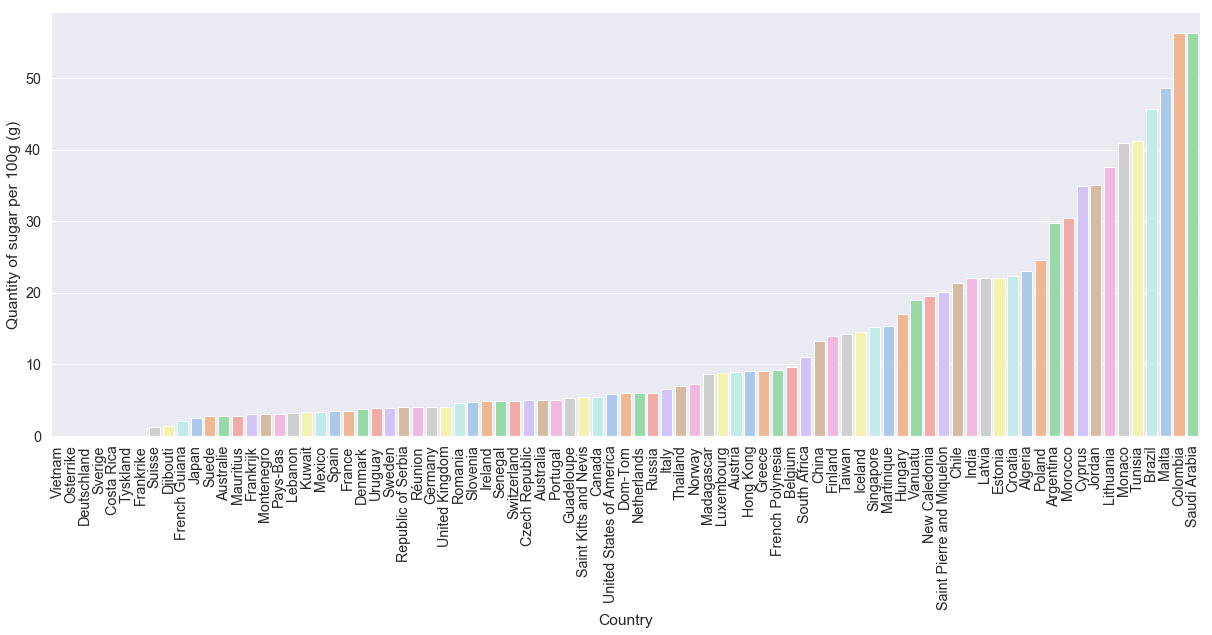

In [28]:
# For each country, find the median value of sugar capacity for all the products in this country
median_sugar = complete_food.groupby("country").median().sugars_100g
median_sugar = median_sugar.sort_values()

# Plot !
#fig,ax = plt.subplots(figsize=(20, 10))
#ax.bar(median_sugar.index,median_sugar.values, align='center', width=1,log=False,edgecolor = "black")
#plt.xticks(rotation=90);

sugar_df = median_sugar.to_frame().reset_index().rename(columns={'country': 'Country', 'sugars_100g': 'Quantity of sugar per 100g (g)'})

sns.set(font_scale=1.3)
g = sns.catplot(x="Country", y="Quantity of sugar per 100g (g)", kind='bar', height=7, aspect=17.5/7, palette='pastel', data=sugar_df);
g.set_xticklabels(rotation=90);

# Save the figure
g.savefig("../AvadarTeam/images/sugar_histogram.png")

In [29]:
print("The percentage of country with a median product containing more than 25g of sugar is "+ \
        str(100*np.sum(median_sugar>=25)/len(median_sugar))+"%")
print("The percentage of country with a median product containing more than 10g of sugar is "+ \
        str(100*np.sum(median_sugar>=10)/len(median_sugar))+"%")

The percentage of country with a median product containing more than 25g of sugar is 13.2530120482%
The percentage of country with a median product containing more than 10g of sugar is 34.9397590361%


With the previous histogram, we can directly say some stuff.

First of all, we notice that the countries in South-America and in the Arab countries. Secondly we also notice that the European countries tend to eat less sugar per 100g in the products sell in those countries. 

Finally, we also notice that the median percent of sugar in the different products is above the 25g of sugar per days. This is the case in approximately 15% of the countries around the world. It is huge, knowing that it is for only one product. This percent get up to more than 40% if we take the products with more than 10g inside. This seems to show that we eat too much sugar!


In [30]:
# We create a DataFrame from the previous Pandas Series
median_sugar_df = pd.DataFrame({'country': median_sugar.index, 'sugars_100g': median_sugar.values})

In [31]:
def AddMissingCountries(df,fileJson,p):
    
    """
    This add the missing countries for a given property. This function can be reuse for other visualizations
    Input: 
        df: a dataframe in which we must add the missing countries
        fileJson: a json file containing all the name of all the countries
        p: the property we want to fill in string format
    Output:
        a dataframe with the good format.
    """
    
    with open(fileJson) as f:
        data = json.load(f)
    feat = data['features']
    for fe in feat:
        prop = fe['properties']
        name = prop['name']
        if (name not in df.country.values):
            df = df.append({'country':name,p:-1},ignore_index=True)
    return df

In [32]:
median_sugar_df = AddMissingCountries(median_sugar_df,DATAPATH+"world-countries.json","sugars_100g")

In [33]:
def plot_choropleth(data_dict, legend, min_val, max_val, colors_list, color_steps=6, location=[30, 0], zoom_start=1.5):
    """
    This function creates a map with a the important information contained in data_dict
    Input:
        data_dict: a dataframe containing the data we want to visualize
        legend: the legend of the plot
        min_val: the minimal value in data_dict
        max_val: the maximal value in data_dict
        colors_list: the list of colors we use to display the map
        color_steps: the number of different colors we need
    Ouput:
        a folium map
    """
    # Create a Folium Map of the World
    world = folium.Map(location=location, tiles='cartodbpositron', zoom_start=zoom_start)

    # Add color range
    linear = folium.branca.colormap.LinearColormap(colors_list, vmin=min_val, vmax=max_val)
    linear = linear.to_step(color_steps)
    
    # Plot custom choropleth map    
    folium.GeoJson(
    geo_json_data,
    style_function=lambda feature: {
        'fillColor':'black' if data_dict[feature['properties']['name']] == -1 else linear(data_dict[feature['properties']['name']]),
        'color': 'black',
        'weight': 1,
        'fill_opacity': 1
    }
    ).add_to(world)
    
    # Add legend for color range
    linear.caption = legend
    world.add_child(linear)


    # Add a legend for cantons with no data
    template = """
    {% macro html(this, kwargs) %}

    <!doctype html>
    <html lang="en">
    <head>
      <meta charset="utf-8">
      <meta name="viewport" content="width=device-width, initial-scale=1">
      <title>jQuery UI Draggable - Default functionality</title>
      <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">
      <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
      <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>
    </head>
    <body>
    <div id='maplegend' class='maplegend' 
        style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
         border-radius:6px; padding: 10px; font-size:14px; right: 20px; bottom: 20px;'>     
    <div class='legend-scale'>
      <ul class='legend-labels'>
        <li><span style='background:grey;opacity:0.8;'></span>Countries for which no data was available</li>
      </ul>
    </div>
    </div>
    </body>
    </html>
    <style type='text/css'>
      .maplegend .legend-scale ul {
        margin: 0;
        margin-bottom: 5px;
        padding: 0;
        float: left;
        list-style: none;
        }
      .maplegend .legend-scale ul li {
        font-size: 80%;
        list-style: none;
        margin-left: 0;
        line-height: 18px;
        margin-bottom: 2px;
        }
      .maplegend ul.legend-labels li span {
        display: block;
        float: left;
        height: 16px;
        width: 30px;
        margin-right: 5px;
        margin-left: 0;
        border: 1px solid #999;
        }
      .maplegend .legend-source {
        font-size: 80%;
        color: #777;
        clear: both;
        }
      .maplegend a {
        color: #777;
        }
    </style>
    {% endmacro %}"""

    macro = MacroElement()
    macro._template = Template(template)

    world.get_root().add_child(macro)

    return world

In [34]:
median_sugar_dict = median_sugar_df.set_index('country')['sugars_100g']
sugar_world = plot_choropleth(median_sugar_dict, 'Quantity of sugar per 100g', 0, max(median_sugar_df["sugars_100g"]), ['white','pink', 'red'], 9)

# Save the map
sugar_world.save('../AvadarTeam/maps/world_sugar.html')

sugar_world

Map : [*Quantity of sugar per 100g*](world_sugar.html)

Seeing the previous map, we can say multiple things:

1) There are a lot of missing values... Those missing values are manely in the south part of the world (e.g. Africa) This could be explained by the fact that there are a lot of poor countries and inform about the product on their country is not their main focus. It could also be explained by the fact that the website OpenFoodFact seems to be more an european thing, mostly because it was created by a french programmer in 2012.

2) The sugar is more present in the countries in the south (even if it is not necessarly those countries that have the most entries in the dataset). The sugar is also present in the Arabic country, maybe reflecting the food culture, in which they use more sweet recipes.

3) Europe doesn't have the most sugar in their product. This could be explain by the fact that maybe the european countries begin to understand that too much sugar is not good for the health...

We can do the same but this time for the vegetables and fruits. But before that we had a function that creates a dictionnnary containing the total number of product sold in a given country

In [35]:
def NumberProductPerCountry(x):
    """
    This function returns a dictionnary with the counts of products that are sold in a country.
    This is apply on a panda series.
    Input:
        x: The argument that will represent each line of the serie
    Output:
        a dictionnary
    """
    for country in x:
            if (country in dictCountry):
                dictCountry[country] +=1
            else:
                dictCountry.update({country:1})
dictCountry = {}
food.countries[food.countries.notnull()].apply(NumberProductPerCountry);

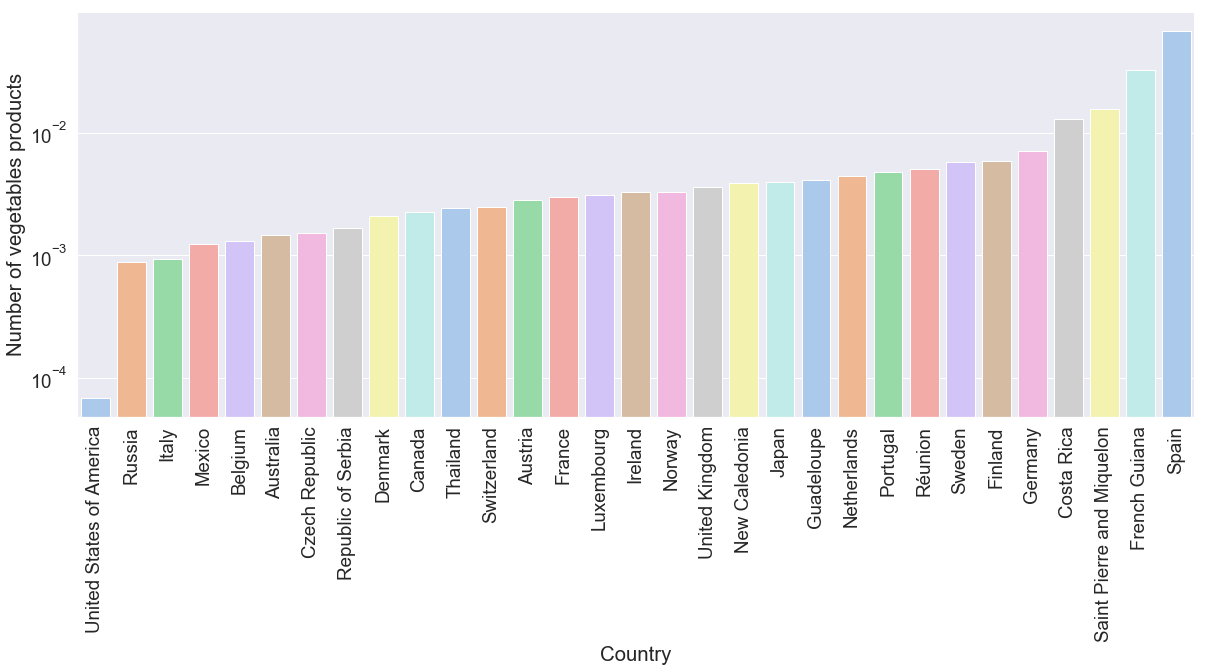

In [36]:
Legume = complete_food.groupby("pnns_groups_2").get_group('Legumes').country.value_counts()
legume = complete_food.groupby("pnns_groups_2").get_group('legumes').country.value_counts()
fruit = complete_food.groupby("pnns_groups_2").get_group('fruits').country.value_counts()
Fruit = complete_food.groupby("pnns_groups_2").get_group('Fruits').country.value_counts()
Vegetable = complete_food.groupby("pnns_groups_2").get_group('Vegetables').country.value_counts()
vegetable = complete_food.groupby("pnns_groups_2").get_group('vegetables').country.value_counts()

Vegetables = Vegetable
Vegetables = Vegetables.add(vegetable,fill_value=0)
Vegetables = Vegetables.add(Fruit,fill_value=0)
Vegetables = Vegetables.add(fruit,fill_value=0)
Vegetables = Vegetables.add(legume,fill_value=0)
Vegetables = Vegetables.add(Legume,fill_value=0)
Vegetables = Vegetables.sort_values()

Vegetables_dict = Vegetables.to_dict()

#We normalize with the total number of products sold in a given country
Vegetables_dict = {k: v/dictCountry[k] for k, v in Vegetables_dict.items()}

Vegetables = pd.Series(Vegetables_dict).sort_values()


veggies_df = Vegetables.to_frame().reset_index().rename(columns={'index': 'Country', 0: 'Number of vegetables products'})


sns.set(font_scale=1.7)
g = sns.catplot(x='Country', y='Number of vegetables products', kind='bar', height=7, aspect=17.5/7, palette='pastel', data=veggies_df, log=True);
g.set_xticklabels(rotation=90);

# Save the figure
g.savefig("../AvadarTeam/vegetables_quantity.png")


This time we notice that in Spain there are the more products sold containing vegetables. This could be explain by the fact that Spain is a country propitious to grow vegetables and thus the more vegetables you have the easier it is to have them in a product. 

We also notice that countries like Sweden and Finland might be in the top of the chart due to the fact that the import a lot of vegetables. 

Finally we notice that the USA are last and quite far away from the other countries. This could be explained by the fact that this country doesn't eat a lot of vegetables (don't we say that America is the kingdom of burgers :-) ) or by the fact that the products that contains vegetables are not register on this website.

In [37]:
# We create a dataframe from the previous pandas Series
Vegetables_df = pd.DataFrame({'country':Vegetables.index, 'vegetables':Vegetables.values})

In [38]:
Vegetables_df = AddMissingCountries(Vegetables_df,DATAPATH+"world-countries.json","vegetables")

In [39]:
Vegetables_dict = Vegetables_df.set_index('country')['vegetables']
vegetables_world = plot_choropleth(Vegetables_dict, 'Quantity of products that are vegetables', 0, max(Vegetables_df["vegetables"]), ['white','yellow', 'orange',  'green'], 20)

# Save the map
vegetables_world.save("../AvadarTeam/maps/vegetables_world.html")

vegetables_world

Map : [Quantity of products that are vegetables](vegetables_world.html)

In the previous map, we firstly see that there are a lot of missing values (the grey on the map). Furthermore, we notice that we can only find a lot of product with vegetables in Europe. This could be explain by the fact that
The countries in Europe consume more vegetables than in the other countries because they've already learn that it can be better for health.

### Goals for the next milestone 

*What until now? What comes next?*

We are quite satisfied with the way we have chosen to handle our data. Our DataFrames are structured and clean, and we are fully clear with each feature and its utility.

We were able to visualize a few results, to make some reasoning and to produce meaningful observations.

For the next Milestone, we will try to work with the other features of our dataset, and maybe find the correlation we were expecting in our main research questions. 

One other point that wasn't mention in the research questions but might also be interesting is to try to see which countries are close to each other in terms of food. We could try to cluster the countries with respect to some features and see if we can see any suprising groups!

### Continuation of the last submission

In [40]:
def CreationForVisualisation(colname, newColName, font_scale=1.5, log=False, data=complete_food):
    """
    This function creates a dataframe and a dictionnary containing the median value of a given column. It also 
    display an histogram
    Input: 
        colname: the name of the column for which we want the dataframe and dict
        newColName: the new name of the column
        font_scale: parameter for the histogram
        log: apply logarithm for the histogram 
        data: which are the datas we use
    Output:
        a dataframe and a dict of the median for each country for a given column
    """
    median_value = data.groupby("country").median()[colname]
    median_value = median_value.sort_values()
    
    nutriment_df = median_value.to_frame().reset_index().rename(columns={'country': 'Country', colname: newColName})
    
    sns.set(font_scale=font_scale)
    g = sns.catplot(x='Country', y=newColName, kind='bar', height=7, aspect=17.5/7, palette='pastel', data=nutriment_df, log=log);
    g.set_xticklabels(rotation=90);
    
    # Save the figure
    g.savefig("../AvadarTeam/images/" + colname + ".png")
    
    # We create a DataFrame from the previous Pandas Series
    median_value_df = pd.DataFrame({'country': median_value.index, colname: median_value.values})
    median_value_df = AddMissingCountries(median_value_df,DATAPATH+"world-countries.json",colname)
    
    median_value_dict = median_value_df.set_index('country')[colname]
    return median_value_df, median_value_dict

First of all, we had some visualizations for the other products. 

Let's start with the energy per 100 grams in the products. We need to transform the kj to kcal by multiplying by a certain factor.

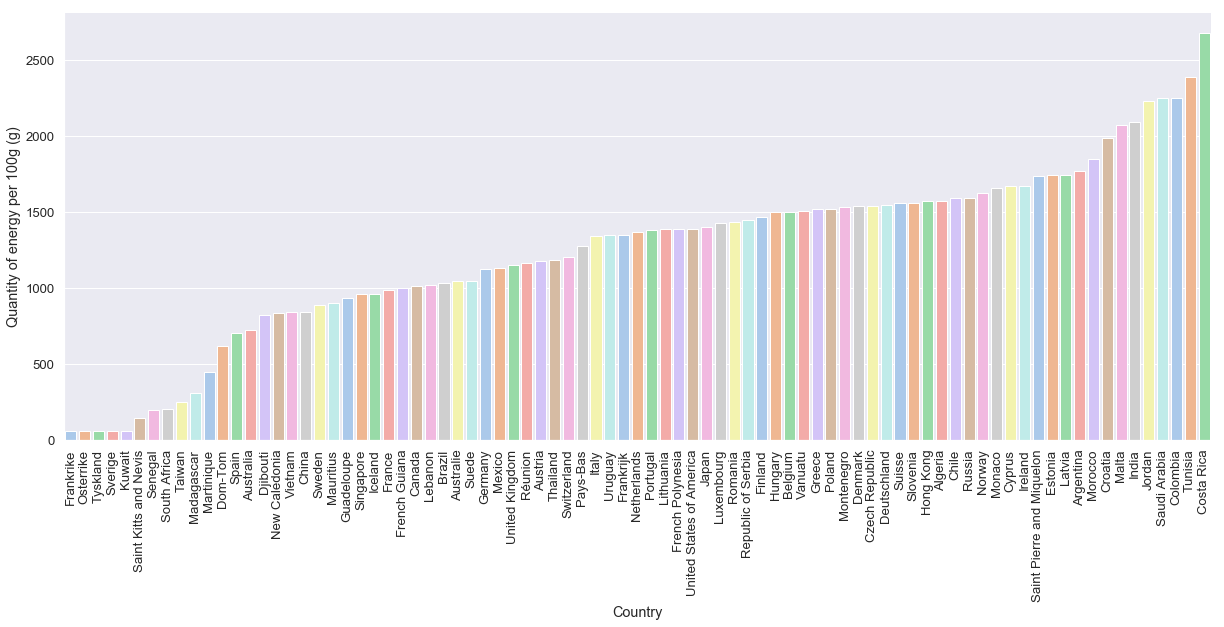

In [41]:
(median_energy_df, median_energy_dict) = CreationForVisualisation("energy_100g", "Quantity of energy per 100g (g)", font_scale=1.2);

In [42]:
energy_world = plot_choropleth(median_energy_dict, 'Quantity of energy per 100g (g)', 0, max(median_energy_df["energy_100g"]), ['white','blue'], 10)

# Save the map
energy_world.save('../AvadarTeam/maps/world_energy.html')

energy_world

Map : [*Quantity of energy per 100g*](world_energy.html)

The quantity of energy seems to be the same in almost all part of the world. We notice some differences in the different continent.

Firstly in Africa, the south part has less energy in their product that the north part.
Secondly in Europe, it is quite homogene. 
Thirdly in Asia, there are also some differences.

This could be explain by the fact that Europe is much more smaller (in terms of area) than Asia and Africa, resulting in more a bigger influence of the different countries on each other. In Africa and Asia, since the distance are bigger between the countries from one end to the other the influence is less important. 
Furthermore, the fact that North Africa is close to Europe tends to confirm our hypothesis, since those countries are closer to Europe than to South-Africa and Madagascar.


We now do the same for the fat per 100g in the different products

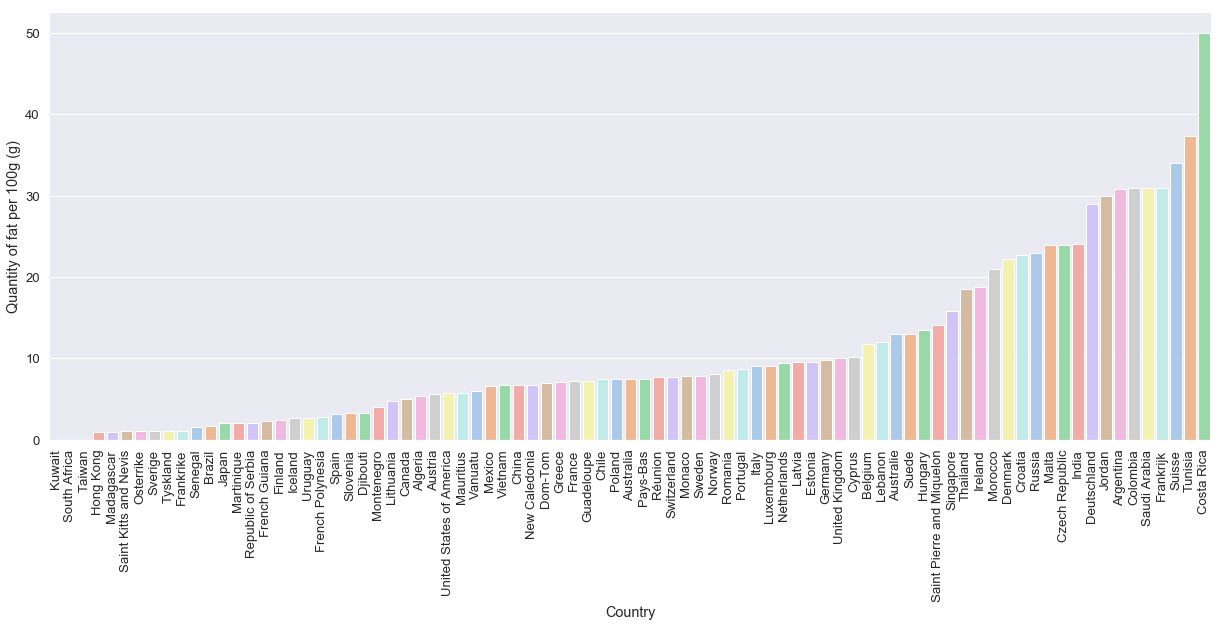

In [43]:
median_fat_df,median_fat_dict = CreationForVisualisation("fat_100g", "Quantity of fat per 100g (g)", font_scale=1.2)
fat_world = plot_choropleth(median_fat_dict, 'Quantity of fat per 100g', 0, max(median_fat_df["fat_100g"]), ['white','yellow', 'orange', 'brown'], 10)

# Save the map
fat_world.save('../AvadarTeam/maps/world_fat.html')

fat_world

Map : [*Quantity of fat per 100g*](world_fat.html)

This time the trend is hard to explain only looking at the visualization. We have that Costa Rica is the country having the most fat per 100g in their product with almost 50g per 100g. That is huge. This means that the in median of all the product, the Costa Rica has a lot of fat. Furthermore, since we use a median, it is not too much influenced by the outliers! A simple explaination would be to say that Costa Rica doesn't have a lot of products on this website, meaning that the only products that were registered contain a lot of fat per 100g. Let's check the number of product register for Costa Rica:

In [44]:
print("The min number of products for a country is : "+ str(min(dictCountry.values())))
print("The max number of products for a country is : "+ str(max(dictCountry.values())))
print("The number of products for Costa Rica is : " + str(dictCountry["Costa Rica"]))
print("The median of the number of products for a country is : " + str(np.median(list(dictCountry.values()))))

The min number of products for a country is : 1
The max number of products for a country is : 457953
The number of products for Costa Rica is : 77
The median of the number of products for a country is : 16.0


We notice that the median for the total number of products sold in a country is equal to 24.0, meaning that Costa Rica belongs to the countries that have a "lot" of products on the database of this website, so the argument that there are not a lot of product isn't so correct. 

Let's also do the same for the satured fat per 100g

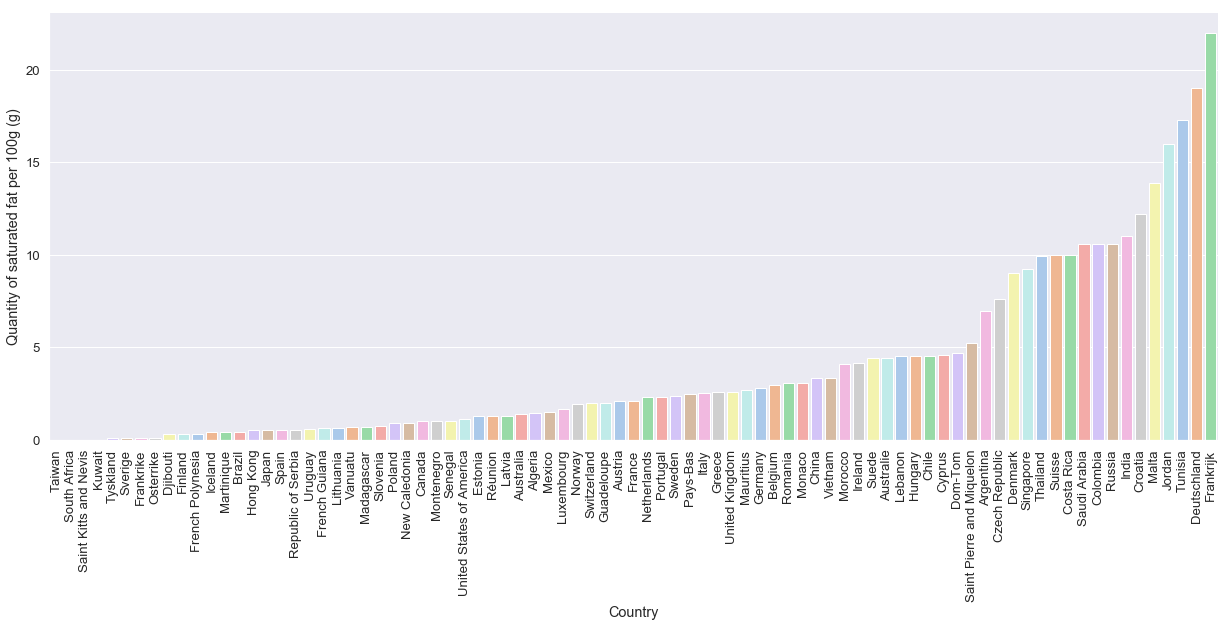

In [45]:
median_Sfat_df,median_Sfat_dict = CreationForVisualisation('saturated-fat_100g', "Quantity of saturated fat per 100g (g)", font_scale=1.2)
Sfat_world = plot_choropleth(median_Sfat_dict, 'Quantity of saturated fat per 100g', 0, max(median_Sfat_df["saturated-fat_100g"]), ['white','yellow', 'orange', 'brown'], 10)

# Save the map
Sfat_world.save('../AvadarTeam/maps/world_Sfat.html')

Sfat_world

Map : [*Quantity of saturated fat per 100g*](world_Sfat.html)

First of all, we notice that the quantity of saturated fat is less present in the products than the fat not saturated. This is a good news since the saturated fat is worse for the health than the non-saturated one. 

Secondly, we notice that this kind of fat is more present in the country at east of Europe (for example in Russia and in India)

Finally there isn't a big distinction between the countries in the south or in the north. It seems to be equilibrated.

We will now try to see what are the countries that are the closest to Switzerland by counting the number of products that are sold in a given country and in Switzerland. 

In [46]:
def ProductSwitzerland(x):
    
    """
    This function returns a dictionnary with only the counts of products that are sold in a country and also 
    sold in Switzerland. This is apply on a panda series
    Input:
        x: The argument that will represent each line of the serie
    Output:
        a dictionnary
    """
    
    totalProduct = 0
    if("Switzerland" in x):
        totalProduct +=1
        for country in x:
            if (country in dictSwiss):
                dictSwiss[country] +=1
            else:
                dictSwiss.update({country:1})
                
    return dictSwiss
       
dictSwiss = {}
food.countries[food.countries.notnull()].apply(ProductSwitzerland);

In [47]:
dictCountry = {}#Contains the number of product sold in each country
food.countries[food.countries.notnull()].apply(NumberProductPerCountry);

In [48]:
total = dictSwiss["Switzerland"]
dictSwiss = {k: (v / dictCountry[k])/total for k, v in dictSwiss.items()} # Contains the normalisation with respect
# to the total number of product sold in a given country

In [49]:
#Prepare the visualization
swiss_world_df = pd.DataFrame(list(dictSwiss.items()),columns = ["country","relatives"])
swiss_world_df.index = range(len(swiss_world_df.relatives))
swiss_world_df["relatives"] =swiss_world_df["relatives"]*10**5 
swiss_world_df = AddMissingCountries(swiss_world_df,DATAPATH+"world-countries.json","relatives")
swiss_world_df
swiss_world_dict = swiss_world_df.set_index('country')["relatives"]

In [50]:
indices = swiss_world_df.loc[:,"relatives"] < 0 
index_non_neg = indices[indices == True].index[0]

switzerland_world_with = plot_choropleth(swiss_world_dict, 'Close to Switzerland', min(swiss_world_df["relatives"][0:index_non_neg]), max(swiss_world_df["relatives"][1::]), ['white', 'yellow', 'red'], 10, [45, 10], 3.5)

# Save the map
switzerland_world_with.save('../AvadarTeam/maps/switzerland_world_normalization1.html')

switzerland_world_with

Map : [*Countries similar to Switzerland (normalized by the number of products sold by country)*](switzerland_world_normalization1.html)

The previous map is a bit confusing at first look. Indeed, it seems that Mali and Zimbabwe are closer to Switzerland, even more than the European countries. This is suprinsing.

However, we must not forget that we divided by the total number of product sold in a given country, meaning that countries that have a lot of product register on this website will be penalized a lot compare to the ones that don't have a lot of products on the website. 

So we can try to do the same but this time only divide by the total number of product sold in Switzerland and not also the total number of product to see if it improves the results.

In [51]:
dictSwiss = {}
food.countries[food.countries.notnull()].apply(ProductSwitzerland);
total = dictSwiss["Switzerland"]
dictSwiss = {k: v/total for k, v in dictSwiss.items()}

swiss_world_df = pd.DataFrame(list(dictSwiss.items()),columns = ["country","relatives"])
swiss_world_df.index = range(len(swiss_world_df.relatives))
swiss_world_df = AddMissingCountries(swiss_world_df,DATAPATH+"world-countries.json","relatives")
swiss_world_df
swiss_world_dict = swiss_world_df.set_index('country')["relatives"]

indices = swiss_world_df.loc[:,"relatives"] < 0 
index_non_neg = indices[indices == True].index[0]

switzerland_world = plot_choropleth(swiss_world_dict, 'Close to Switzerland', min(swiss_world_df["relatives"][0:index_non_neg]), max(swiss_world_df["relatives"][1::]),['white', 'yellow', 'red'],10, [45, 10], 3.5)

# Save the map
switzerland_world.save('../AvadarTeam/maps/switzerland_world_normalisation2.html')

switzerland_world

Map : [*Countries similar to Switzerland (normalized by the number of products sold by Switzerland)*](switzerland_world_normalization1.html)

This time, France is the country that is the closest to Switzerland. But this time, we could be influenced by the fact that there is much more products sold in France than in any country in the world. It will be easier for France to have products in commun with Switzerland than the other countries. 

### K-mean clustering

We now do the final step of this data analysis. We will check what are the country that are the closest to each other with the nutriments contain in them. We first compute the median for each nutriment. This will give us a dataframe on which we will apply the clustering.

In [52]:
code_country = complete_food[['code', 'country']].set_index('code')

In [53]:
food_country = code_country.merge(nutriments, left_index=True, right_on='code', how='outer').set_index('code')

In [54]:
grouped_country = food_country.groupby('country')

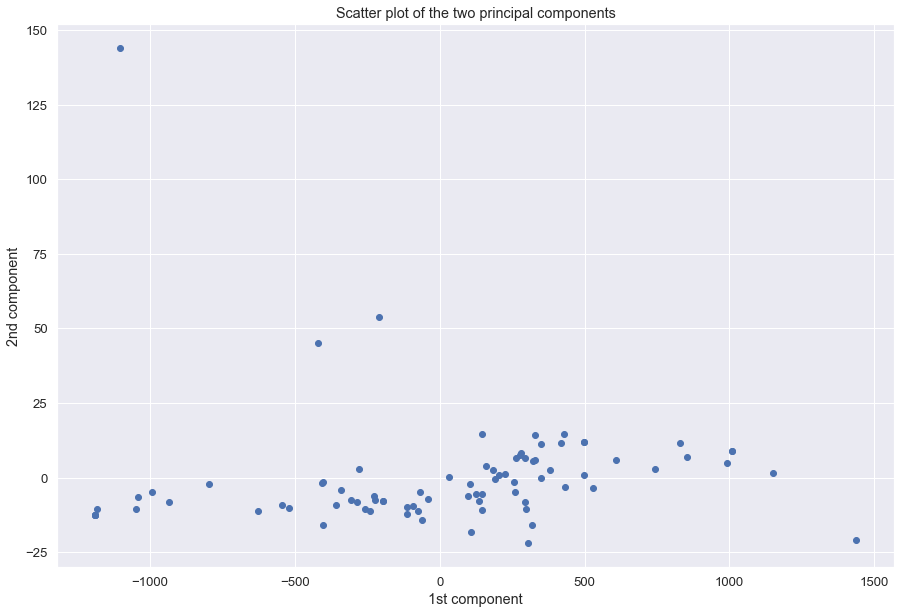

In [55]:
# The median for each country and for each products can now be computed
mean_country = grouped_country.median() 
np_mean_country = mean_country.values

# We also compute the PCA in order to try to determine the number of cluster looking at the scatter plot
pca = PCA(n_components=2,copy=True)
np_mean_country_reduced = pca.fit_transform(np_mean_country)
plt.figure(figsize=(15, 10))
plt.title('Scatter plot of the two principal components')
plt.xlabel('1st component')
plt.ylabel('2nd component')
plt.scatter(np_mean_country_reduced.T[0],np_mean_country_reduced.T[1])

Looking at the previous scatter plot, we notice that it seems to have 3 outliers (one at y = 150 and two around y = 50). If we try to remove those values and rerun the pca, we might have a better second component.

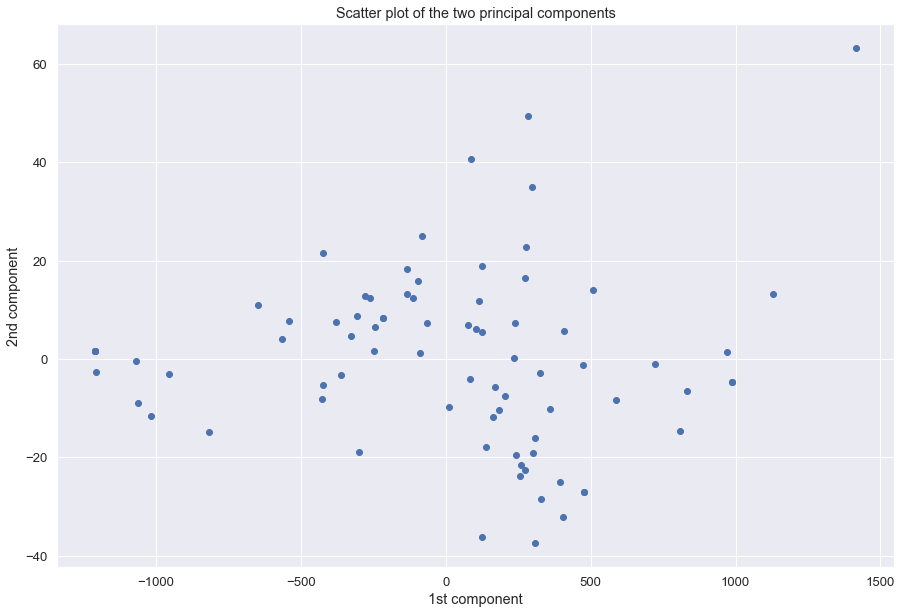

In [56]:
#Find the index of the values that are not outliers
indexGood = np.where(np_mean_country_reduced.T[1] < 25)
np_mean_country = np_mean_country[indexGood]
pca = PCA(n_components=2,copy=True)
np_mean_country_reduced = pca.fit_transform(np_mean_country)
plt.figure(figsize=(15, 10))
plt.title('Scatter plot of the two principal components')
plt.xlabel('1st component')
plt.ylabel('2nd component')
plt.scatter(np_mean_country_reduced.T[0],np_mean_country_reduced.T[1])

It is hard to tell how many clusters we are suppose to take. We will try an automatic approach to select the number of clusters

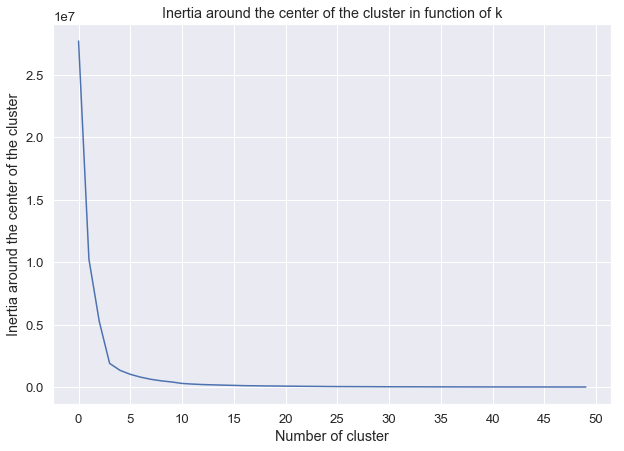

In [57]:
number_clustering = 50
kmeans_np = np.zeros(number_clustering)
for k in range(number_clustering):
    kmeans = KMeans(n_clusters=k+1, random_state=0).fit(mean_country)
    kmeans_np[k] = kmeans.inertia_
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
plt.title("Inertia around the center of the cluster in function of k")
plt.xlabel('Number of cluster')
plt.xticks(np.arange(0, 51, 5))
plt.ylabel('Inertia around the center of the cluster')

plt.plot(kmeans_np);
plt.savefig("../AvadarTeam/images/cluster_intertia.png")

By looking at the previous plot, we seem to see that the good amount of cluster should be around 3 since at this moment, the sum of the distance from the different centers of the different clusters doesn't deacrease significantly. We can now compute the clustering using 3 clusters.

In [58]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(mean_country)

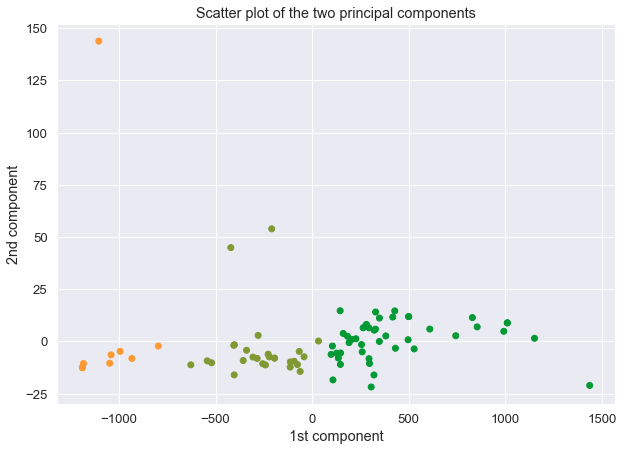

In [59]:
# We do the previous scatter plot with all the point in order to visualize the different clusters.
np_mean_country = mean_country.values
pca = PCA(n_components=2,copy=True)
np_mean_country_reduced = pca.fit_transform(np_mean_country)

colors = [[5*k/10,0.6,0.2] for k in kmeans.labels_] 

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
plt.title("Scatter plot of the two principal components")
plt.xlabel('1st component')
plt.ylabel('2nd component')
plt.scatter(np_mean_country_reduced.T[0],np_mean_country_reduced.T[1],c=colors)
plt.savefig("../AvadarTeam/images/pca.png")

We notice that the 1st component seem to have the most importance in the clustering of the values. This means that only one column seem to have some importance in the clustering of the countries. Let's find out which column it is!

In [60]:
pd.DataFrame(pca.components_,columns=mean_country.columns,index=["PC-1","PC-2"])

energy_100g  fat_100g  saturated-fat_100g  carbohydrates_100g  \
PC-1     0.999448  0.012436            0.004544            0.026672   
PC-2    -0.003840 -0.087334           -0.038086            0.371652   

      sugars_100g  proteins_100g  salt_100g  sodium_100g  
PC-1     0.011839       0.003699  -0.007371    -0.002898  
PC-2     0.208723      -0.046314   0.836059     0.328751

So we notice that the column that as the more impact is the column energy! This is not surprinsing if we look at the map of the world when we choose to use 3 clusters. The countries that are clustered together are indeed the the same that have the same colour on the map of the energy.

In [61]:
# We choose to use 3 clusters otherwise we seem to have too much cluster (that are too small)
nb_cluster = 3
kmeans = KMeans(n_clusters=nb_cluster, random_state=0).fit(mean_country)
kmeans.labels_
cluster_dict = dict.fromkeys(list(mean_country.index))
for index,country in enumerate(mean_country.index):
    cluster_dict[country] = kmeans.labels_[index] 

cluster_df = pd.DataFrame({'country':list(cluster_dict.keys()), 'cluster':list(cluster_dict.values())})
cluster_df = AddMissingCountries(cluster_df,DATAPATH+"world-countries.json","cluster")
cluster_dict = cluster_df.set_index('country')['cluster']


world_cluster = plot_choropleth(data_dict=cluster_dict,color_steps=nb_cluster,colors_list=["red","blue","green"],legend="Country clustering",min_val=0,max_val= nb_cluster-1)

# Save the map
world_cluster.save('../AvadarTeam/maps/world_cluster.html')

world_cluster

Map : [*Countries' similarity (3 clusters)*](world_cluster.html)

This is quite interesting to see which countries are close to each other in terms of the nutriments (especially, as we saw, in terms of the energy per 100g). 

For example, Switzerland and France aren't that similar... This is not suprising if we consider that in Switzerland, a majority of the people speak german and thus will be influenced by the culture of Germany more than the one of France. Furthermore, we notice that Italy is also in the same cluster as Germanym thus influencing more the food culture in Switzerland.

An other interesting information that we get from this map is the fact that the Senegal has the same color as France. This could be explained by the fact that Senegal was under the influence of France during multiple years! This could then explain that those two countries consumes the same type of product and thus they consumes the same amount of each nutriments. Note that this is also influenced by the fact that the products that are register on this openFoodFacts come a lot from France and thus when a person register a product, he might also register all the countries in which there are sold, meaning that he will also register this product for Senegal. 

Again, considering France, we notice that this country is close to Canada. A possible explaination is that a lot of products that are on this website might come from Quebec, influencing the entire country.

Finally, also countries that are not next to each other can be in the same cluster. This is for example the case for Columbia and India. This is hard to explain but it is interesting to notice that those two countries are close to each other in terms of nutriments. This could show that they share a similar food culture! 
One possible explaination would be that in Columbia, there are a lot of people living in the mountains (Bogota, the capital, is at 2640 meters above sea level). Thus they might consume more energy (for example if the weather is cold), meaning that they will need to consume more energy to compensate for the loss of energy. In India, the weather is quite hot, so the persons living there also consume a lot of energy (for example to cool the body) meaning that they also need to compensate for the loss of energy.

Finally, as a last visualization of the clustering, we can do a dendogram. 

In [62]:
# generate the linkage matrix
Z = linkage(mean_country, 'ward')

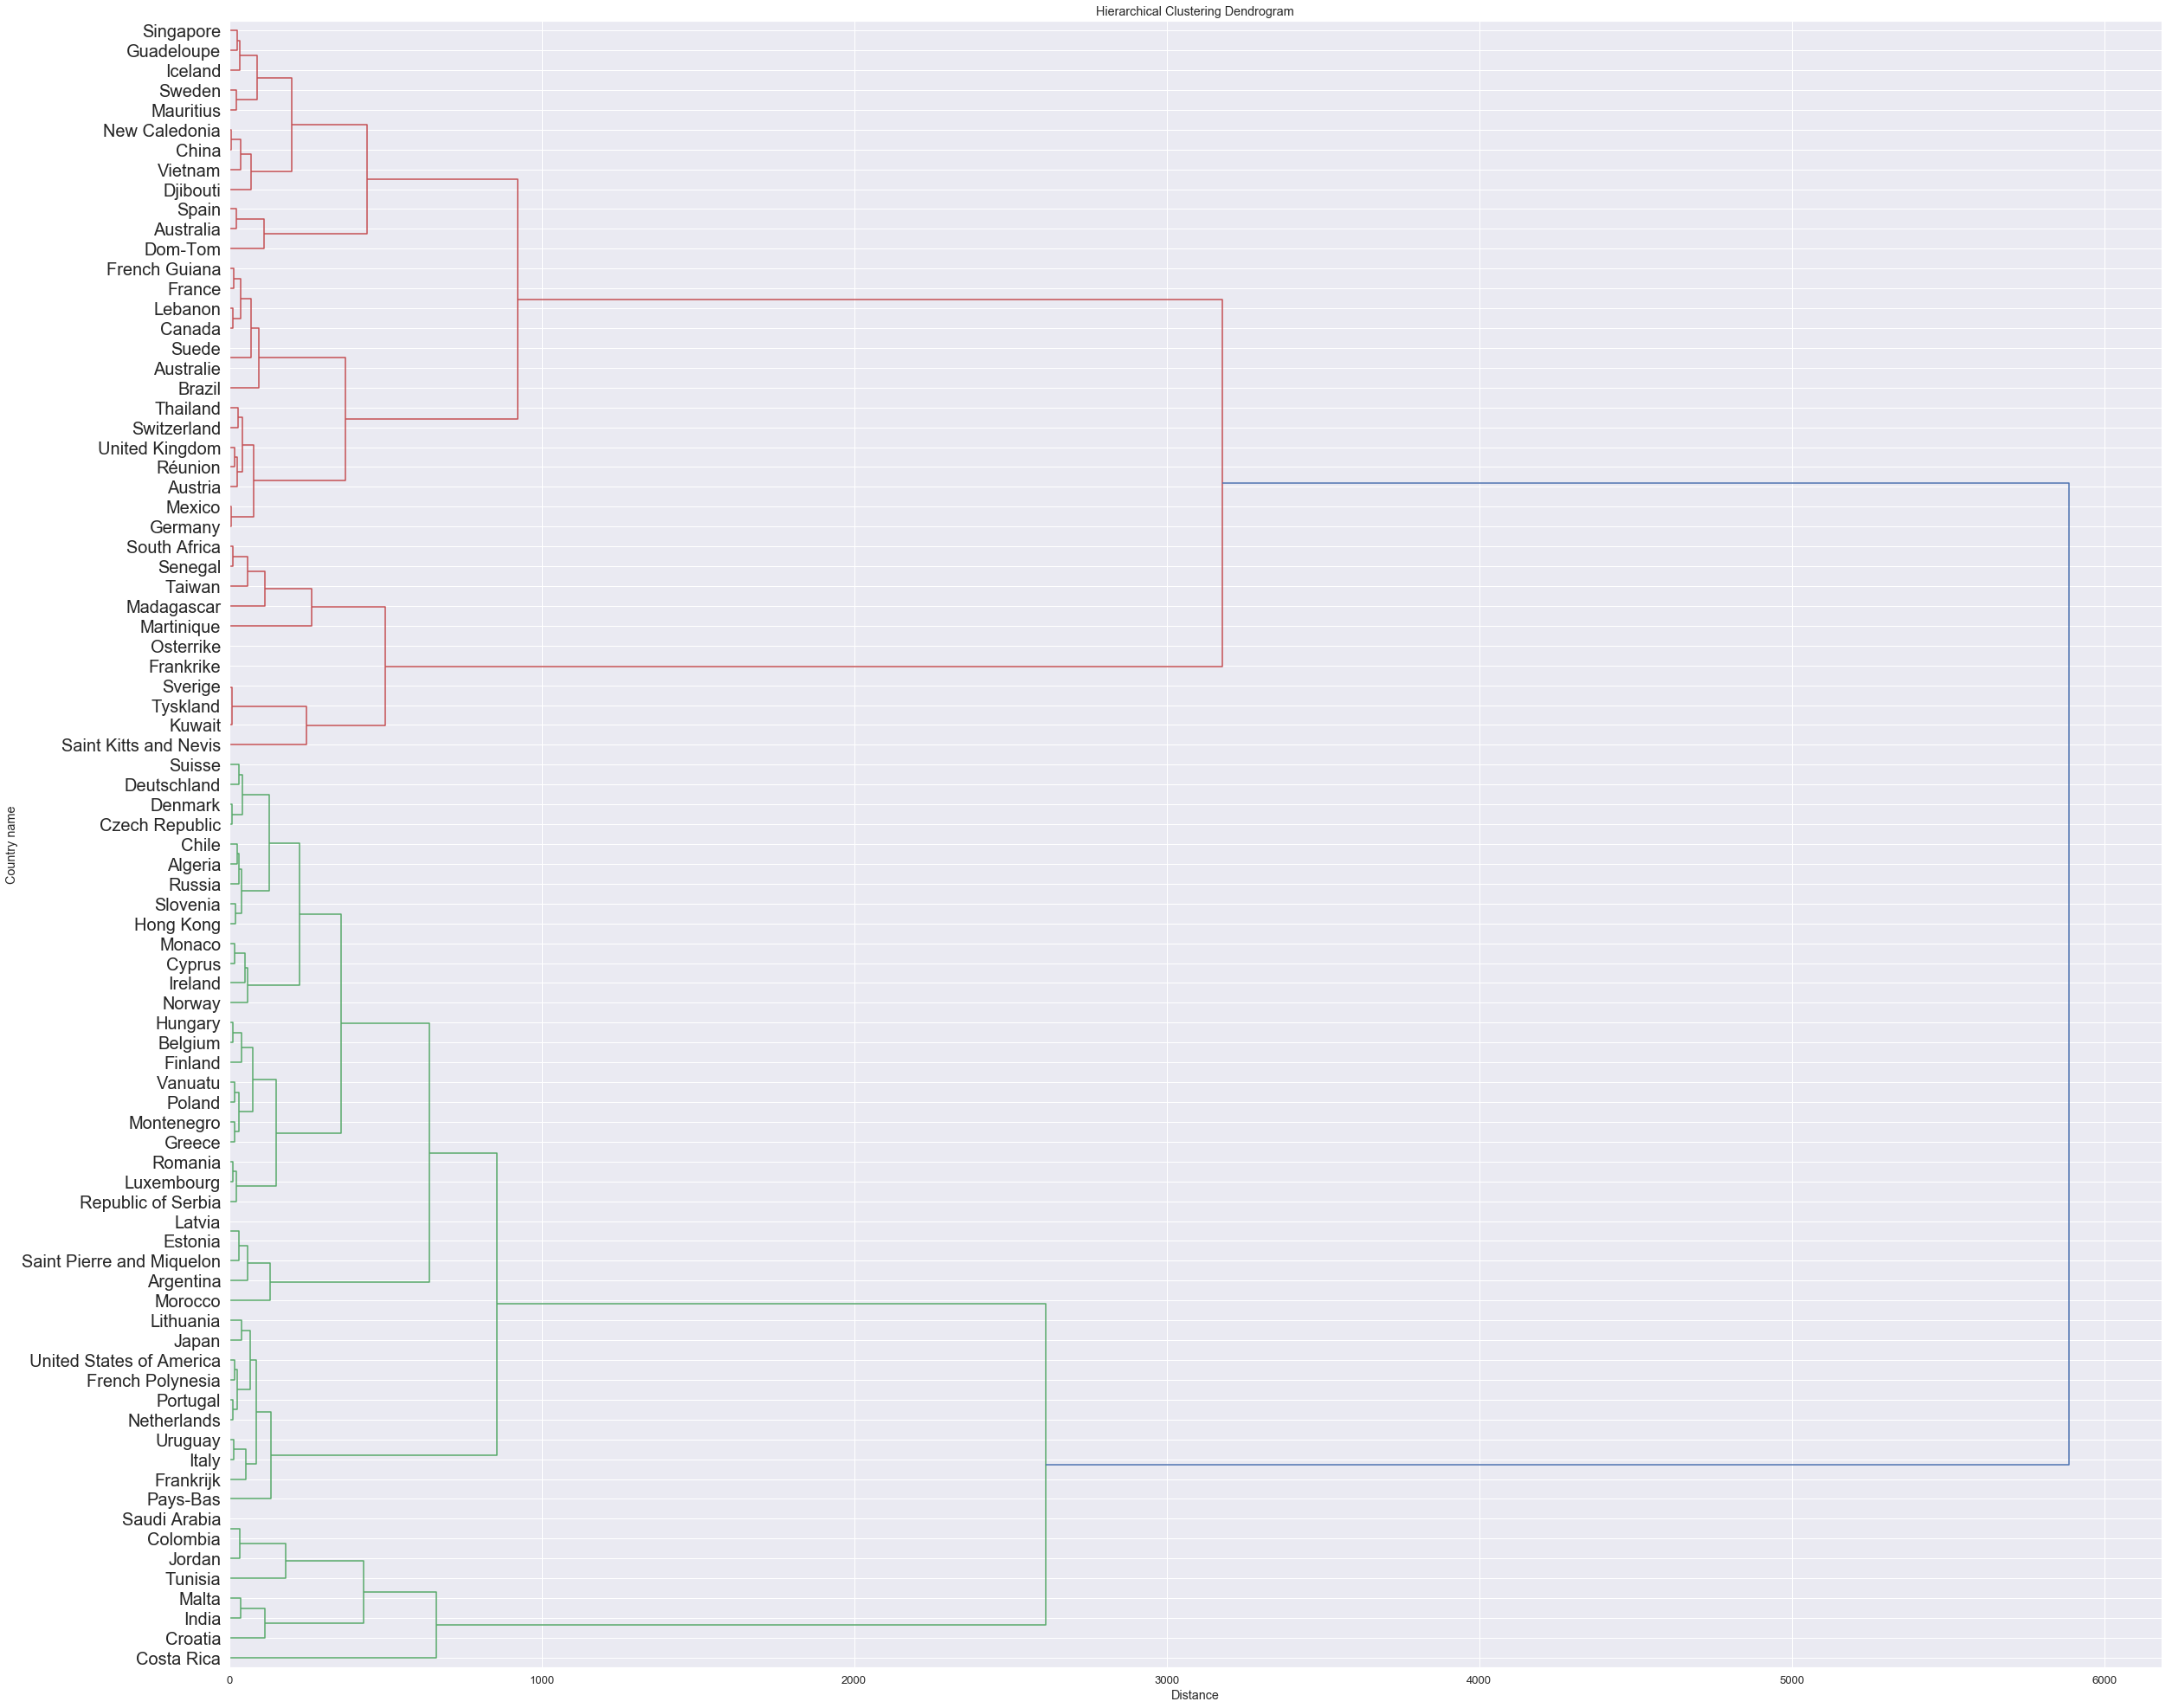

In [63]:
# calculate full dendrogram
plt.figure(figsize=(40, 35))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Distance')
plt.ylabel('Country name')
dendrogram(
    Z,
    leaf_rotation=0.,  # rotates the x axis labels
    leaf_font_size=20.,  # font size for the x axis labels
    labels=mean_country.index,
    orientation="right"
)
# Save the figure
plt.savefig("../AvadarTeam/images/dendrogram.png")

# Display the figure
plt.show()

In this previous plot, we also see the three cluster. One is the green one with the distance just below 1000 and the two others are the two red ones with the distance below 1000. Note that the last 6 are quite different from the other countries. This difference may let us think that 4 clusters could be a good idea. However, at first we tried with 3 clusters, but it might interesting to test with 4 clusters. Let's do this!

In [64]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(mean_country)

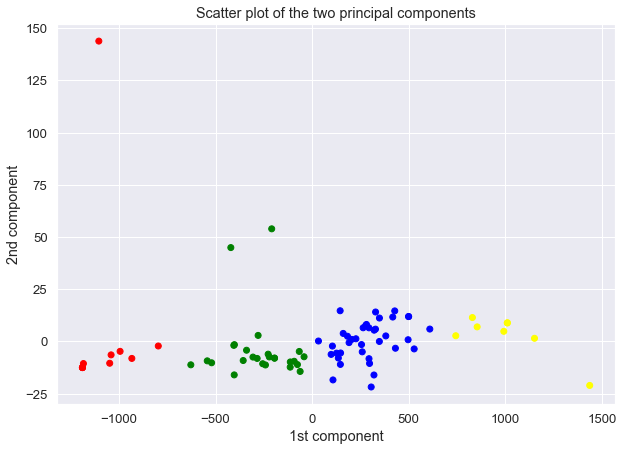

In [65]:
# We do the previous scatter plot with all the point in order to visualize the different clusters.
np_mean_country = mean_country.values
pca = PCA(n_components=2,copy=True)
np_mean_country_reduced = pca.fit_transform(np_mean_country)

colors = []
for k in kmeans.labels_:
    c = "black"
    if k == 0:
        c = "red"
    if k ==1:
        c = "blue"
    if k == 2:
        c = "green"
    if k ==3:
        c = "yellow"
    colors.append(c)

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
plt.title("Scatter plot of the two principal components")
plt.xlabel('1st component')
plt.ylabel('2nd component')
plt.scatter(np_mean_country_reduced.T[0],np_mean_country_reduced.T[1],c=colors)
plt.savefig("../AvadarTeam/images/pca2.png")

This time we notice that it seems to cluster a bit better than previously. This can be seen in the previous scatter plot when you look at the group of green dot that are a distant from the other dots in the scatter plot.

We can now plot the map as before

In [66]:
# We choose to use 4 clusters otherwise we seem to have too much cluster (that are too small)
nb_cluster = 4
kmeans = KMeans(n_clusters=nb_cluster, random_state=0).fit(mean_country)
kmeans.labels_
cluster_dict = dict.fromkeys(list(mean_country.index))
for index,country in enumerate(mean_country.index):
    cluster_dict[country] = kmeans.labels_[index] 

cluster_df = pd.DataFrame({'country':list(cluster_dict.keys()), 'cluster':list(cluster_dict.values())})
cluster_df = AddMissingCountries(cluster_df,DATAPATH+"world-countries.json","cluster")
cluster_dict = cluster_df.set_index('country')['cluster']


world_cluster2 = plot_choropleth(data_dict=cluster_dict,color_steps=nb_cluster,colors_list=["red","blue","green","yellow"],legend="Country clustering",min_val=0,max_val= nb_cluster-1)

# Save the map
world_cluster2.save('../AvadarTeam/maps/world_cluster_4.html')

world_cluster2

Map : [*Countries' similarity (4 clusters)*](world_cluster_4.html)

This time it is interesting to notice that in Europe we have the center that is blue and the others that countries that are red. It is also interesting to notice this time that France, Switzerland and Germany are in the same cluster, meaning that with 3 clusters, those 3 countries where on the edge and that they would nearly be in the same cluster already with 3 clusters. 

As before, Columbia are close to each other in terms of energy, but as seen in all the maps before, there where often very close (for sugar, energy and so on). So it is not that suprinsing to see them still so close.

### Conclusion of the notebook

This dataset was not easy to handle for two main reasons:

* There were a lot of missing values. So it was hard to deal with them. We choosed to remove those values because usually all the row was corrupted

    
* Some rows were filled but incorrectly or inconsistently with respect to the rest of the datas. For example, we had to deal manually with the country's names. It would have been easier for the website to create a list in which the user can select the country instead of letting him write the country's name of his choice

After this cleaning part that was not so nice, we had to learn something from the datas. We tried to learn something about the nutriments in the different products and how they were consumed in each country. From that we notice that sugar was far too much consumed and that the energy in the product was one of the major factor in order to compare the different countries and see which ones could be cluster to each other.

Finally, we will just say that even if we had some results that might be interesting and that could be explained by some different arguments (geographically for example) one should be aware that those results were found on few datas. There were a lot of missing values and for some countries we didn't have any informations. In short, do not surinterpret our results!